global file
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
raw_file = file

In [509]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import math
import pandas as pd
import  os as os
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt


In [510]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')

cg = CoinGeckoAPI()

In [511]:
snapshot.Proposal.datetime = SyntheticField(
  lambda timestamp: str(datetime.fromtimestamp(timestamp)),
  SyntheticField.STRING,
  snapshot.Proposal.end,
)

In [512]:
spaces = snapshot.Query.spaces(
    first=5000,
    orderby = 'name',
    orderdirection = 'asc'
)

spaces_list = sg.query_df([
    spaces.name
])
spaces_list

In [513]:
spacename = input('spacename plz?')
# based on their url, for example "curve.eth" for  https://snapshot.org/#/curve.eth


In [514]:
proposals = snapshot.Query.proposals(
  orderBy='created',
  orderDirection='desc',
  first=10000,
  where=[
    snapshot.Proposal.space == spacename, ##'fuse.eth',
    snapshot.Proposal.state == 'closed'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)


In [515]:
proposals_snapshots = sg.query_df([
    proposals.title,
    proposals.id,
    proposals.body,
    proposals.scores_total,
    proposals.created
])

In [516]:
proposals_choices = sg.query(proposals.choices)

In [517]:
proposals_choices = pd.DataFrame(proposals_choices)

In [518]:
olympus_governance_view = pd.concat([proposals_snapshots,proposals_choices], axis=1)

In [519]:
##let's view the output just to make sure
olympus_governance_view.head(5)

,proposals_title,proposals_id,proposals_body,proposals_scores_total,proposals_created,0,1,2,3,4
0,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,Please select one token you want to be added t...,14982.671060,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC)
1,Close STORM to STMX Swap Proposal,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,This proposal is for the closing of the curren...,18066.756311,1649805388,A,B,C,None,None


In [520]:
#let's remove duplicate rows the easy way, and add the name of the DAO to the table
olympus_governance_view_clean = olympus_governance_view.copy(deep=True)
olympus_governance_view_clean = db.query("select "
                                 "  *"
                                 "  , (to_timestamp((proposals_created::bigint)))::date proposal_date  "
                                 ""
                                 "from olympus_governance_view").df()
#make sure we know which DAO we are working with
olympus_governance_view_clean.insert(0, 'DAO', spacename)
olympus_governance_view_clean.head(10)

,DAO,proposals_title,proposals_id,proposals_body,proposals_scores_total,proposals_created,0,1,2,3,4,proposal_date
0,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,Please select one token you want to be added t...,14982.671060,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22
1,stormxio.eth,Close STORM to STMX Swap Proposal,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,This proposal is for the closing of the curren...,18066.756311,1649805388,A,B,C,NaN,NaN,2022-04-12


In [521]:
total_proposals = len(olympus_governance_view_clean)
total_proposals

2

In [522]:
max_index = len(olympus_governance_view_clean.columns)
max_index

12

In [495]:
path =file+'/'+spacename+'_proposals_table_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'_proposals.csv'
olympus_governance_view_clean.to_csv(path, index = False)

OSError: Cannot save file into a non-existent directory: 'olympusdao.eth'

In [525]:
proposal_id = olympus_governance_view_clean.iloc[0,2]
proposal_id

'0x5bf3110333575357306fe55ca430116cd29a9d924794b50da32aa92e7003b356'

In [526]:
vote_tracker = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=10000,
where=[
  snapshot.Vote.proposal == proposal_id
]
)

In [527]:
voting_snapshots_list_pre = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
])

In [528]:
voting_snapshots_list = db.query("select "
                                 "  *"
                                 "  , to_timestamp((votes_Created::bigint)) vote_timestamp  "
                                 ""
                                 "from voting_snapshots_list_pre").df()

In [529]:
voting_snapshots_list.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,vote_timestamp
0,bafkreibl6nvmovtjyuuj47jwhgzskqzniqu42cvuqamjy...,0x6585eC2D632442c1528088307418537d7D091584,1659696323,1,207.130199,2022-08-05 10:45:23
1,bafkreihhjyhiukvc5vjdi5f7ggkpfq4klsar3vq5xqgdr...,0xE368a7dDa63936275a0A58f93cE36be0c9676E85,1659645575,2,29.368031,2022-08-04 20:39:35
2,0x08074229e53e4174a6b23c60db712fca129942ddd97b...,0x2Fcc797911A69EE6ad1adC1bDc476c8d589599bF,1659641836,2,156.017895,2022-08-04 19:37:16
3,0xaf7a17a86daa13c978ba987e9b4f47849a90bf12dbfc...,0xf20A0C27ED8Adf6C9Fc60C1FE71e27D997966D33,1659639505,2,11.818299,2022-08-04 18:58:25
4,0xef9056ca245a09278809f4df9abff161dccd38df8d33...,0x199a051119AD6164E6645dbFE73D431440B1Fb87,1659609743,1,621.105506,2022-08-04 10:42:23
5,bafkreibkzjgjbl4jjt5flmludfkfaoj35igofbdvwmr3u...,0xe25459E909361263809052b07E80DCCcc4100067,1659593330,2,1040.758411,2022-08-04 06:08:50
6,bafkreicmsurg4lnu7fgo5ja2helz6tjwa52vat2i5uurt...,0xc5D074D8F2c68e4F6932338a0d192043ACC85e19,1659491176,2,136.503987,2022-08-03 01:46:16
7,0x989a1184d73812c8d8de780fe06bd60a99c2f609b1e3...,0x165bD5e83ab345dc3448dF500e5ef57779E4c73a,1659466868,1,15.608447,2022-08-02 19:01:08
8,bafkreig2c25lwt6kxqeeiinintgts3jsroj7lkcs34kir...,0x764b3973f0980Ecd8C3242a868F223f5D125249c,1659276394,2,161.292737,2022-07-31 14:06:34
9,0x71f60c6bb387fe607f1ed107037a20b56987827a6938...,0x10b89b85395a33e46f79d66D711711Acc6A6a3bC,1659131837,1,13.258150,2022-07-29 21:57:17


In [530]:
x=0
while x <total_proposals:
    proposal_id = olympus_governance_view_clean.iloc[x,2]

    vote_tracker = snapshot.Query.votes(
    orderBy = 'created',
    orderDirection='desc',
    first=10000,
    where=[
      snapshot.Vote.proposal == proposal_id
    ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    voting_snapshots['Proposal'] = proposal_id
    voting_snapshots_list=pd.concat([voting_snapshots_list, voting_snapshots])

    x=x+1
    progress = 100*(round(x/total_proposals,0))
    ##clear_output(wait=True)

print(len(voting_snapshots_list),' records')

154  records


In [502]:
#spit out the file
path =file+'/'+spacename+'_voting_snapshots_list_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'.csv'
voting_snapshots_list.to_csv(path, index = False)

OSError: Cannot save file into a non-existent directory: 'olympusdao.eth'

In [532]:
#I join these two tables to create my charts as it makes life easier. We are going to build the charts here now, so here we go
governance_data = pd.merge(voting_snapshots_list, olympus_governance_view_clean, how='inner', left_on='Proposal', right_on='proposals_id')
del governance_data["proposals_body"] #breaks the table with weird characters
#governance_data["vote_value"] = governance_data["votes_vp"]*governance_data["usd_price"]
governance_data.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,vote_timestamp,Proposal,DAO,proposals_title,proposals_id,proposals_scores_total,proposals_created,0,1,2,3,4,proposal_date
0,bafkreibl6nvmovtjyuuj47jwhgzskqzniqu42cvuqamjy...,0x6585eC2D632442c1528088307418537d7D091584,1659696323,1,207.130199,NaT,0x5bf3110333575357306fe55ca430116cd29a9d924794...,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,14982.67106,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22
1,bafkreihhjyhiukvc5vjdi5f7ggkpfq4klsar3vq5xqgdr...,0xE368a7dDa63936275a0A58f93cE36be0c9676E85,1659645575,2,29.368031,NaT,0x5bf3110333575357306fe55ca430116cd29a9d924794...,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,14982.67106,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22
2,0x08074229e53e4174a6b23c60db712fca129942ddd97b...,0x2Fcc797911A69EE6ad1adC1bDc476c8d589599bF,1659641836,2,156.017895,NaT,0x5bf3110333575357306fe55ca430116cd29a9d924794...,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,14982.67106,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22
3,0xaf7a17a86daa13c978ba987e9b4f47849a90bf12dbfc...,0xf20A0C27ED8Adf6C9Fc60C1FE71e27D997966D33,1659639505,2,11.818299,NaT,0x5bf3110333575357306fe55ca430116cd29a9d924794...,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,14982.67106,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22
4,0xef9056ca245a09278809f4df9abff161dccd38df8d33...,0x199a051119AD6164E6645dbFE73D431440B1Fb87,1659609743,1,621.105506,NaT,0x5bf3110333575357306fe55ca430116cd29a9d924794...,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,14982.67106,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22
5,bafkreibkzjgjbl4jjt5flmludfkfaoj35igofbdvwmr3u...,0xe25459E909361263809052b07E80DCCcc4100067,1659593330,2,1040.758411,NaT,0x5bf3110333575357306fe55ca430116cd29a9d924794...,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,14982.67106,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22
6,bafkreicmsurg4lnu7fgo5ja2helz6tjwa52vat2i5uurt...,0xc5D074D8F2c68e4F6932338a0d192043ACC85e19,1659491176,2,136.503987,NaT,0x5bf3110333575357306fe55ca430116cd29a9d924794...,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,14982.67106,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22
7,0x989a1184d73812c8d8de780fe06bd60a99c2f609b1e3...,0x165bD5e83ab345dc3448dF500e5ef57779E4c73a,1659466868,1,15.608447,NaT,0x5bf3110333575357306fe55ca430116cd29a9d924794...,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,14982.67106,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22
8,bafkreig2c25lwt6kxqeeiinintgts3jsroj7lkcs34kir...,0x764b3973f0980Ecd8C3242a868F223f5D125249c,1659276394,2,161.292737,NaT,0x5bf3110333575357306fe55ca430116cd29a9d924794...,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,14982.67106,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22
9,0x71f60c6bb387fe607f1ed107037a20b56987827a6938...,0x10b89b85395a33e46f79d66D711711Acc6A6a3bC,1659131837,1,13.258150,NaT,0x5bf3110333575357306fe55ca430116cd29a9d924794...,stormxio.eth,Add Withdrawal Token,0x5bf3110333575357306fe55ca430116cd29a9d924794...,14982.67106,1658523142,Dogecoin (DOGE),Cardano (ADA),Pluton (PLU),BNB (BNB),Polygon (MATIC),2022-07-22


In [ ]:
#Spit out the file, but save it in its own folder for easy access
final_file = file+'\\'+'final'
final_raw_file = final_file
os.makedirs(final_raw_file, exist_ok=True)
final_path =file+'\\'+spacename+'governance_data_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(governance_data))+'.csv'
governance_data.to_csv(final_path, index = False)

In [535]:
crunch_data = db.query("select "
                           "Proposal"
                           ",votes_voter "
                           ",votes_choice"
                           ",votes_vp"
                           ",votes_created "
                       "    ,proposals_title "
                       "    ,proposal_date"
                    "       , to_timestamp(min(votes_Created::bigint)) proposal_date "
                           ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp "
                           ",sum(votes_vp) over (Partition by Proposal) as total_vp "
                           ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                           ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                       ",round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                           ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                           ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                           ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                           ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                       "from "
                       "    governance_data  "
                       ""
                       "Group by "
                       "    Proposal"
                       "    ,votes_voter"
                       "    ,votes_choice"
                       "    , votes_vp "
                       "    , votes_created "
                       "    , proposals_title "
                       "    ,proposal_date "
                       ""
                       "Order by "
                       "    7 asc, "
                       "    votes_vp desc "
                       "    , votes_created asc"
                       "").df()


crunch_data.insert(0, 'DAO', spacename)
crunch_data.head(n=10)


,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,proposals_title,proposal_date,proposal_date_2,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
0,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x862A9c8d5428EB09035C3dDFb19ACb87D88d2c59,1,4328.091621,1649959012,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-14 17:56:52,4328.091621,18066.756311,0.239561,0.239561,0.0,1,1,0.009804,1.0
1,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x190976E54Fb12fAb0E63c6fa9cb3cB4245b9D52a,2,4328.028833,1650018486,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-15 10:28:06,8656.120454,18066.756311,0.239558,0.479119,0.0,2,2,0.019608,2.0
2,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x015cE33498Af451706aDD0d02c2ccE492F00801e,1,1011.797911,1650212488,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-17 16:21:28,9667.918365,18066.756311,0.056003,0.535122,1.0,3,3,0.029412,3.0
3,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0xF7C9D7c8E082382598B5e1fc8D92e25fe6cbE00e,1,897.447141,1649982220,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-15 00:23:40,10565.365506,18066.756311,0.049674,0.584796,1.0,4,4,0.039216,4.0
4,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0xe25459E909361263809052b07E80DCCcc4100067,3,694.768852,1650134374,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-16 18:39:34,11260.134358,18066.756311,0.038456,0.623252,1.0,5,5,0.049020,5.0
5,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x2E905B0436bcFb317838b6dd6f1A4B73088d78D2,1,581.858087,1650057876,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-15 21:24:36,11841.992445,18066.756311,0.032206,0.655458,1.0,6,6,0.058824,6.0
6,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x3C27284E0CCC5f7e772aB880C661720D0d199572,1,459.253533,1649820253,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-13 03:24:13,12301.245978,18066.756311,0.025420,0.680877,1.0,7,7,0.068627,7.0
7,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x62340e1ad4862E5cA5E9f48E9A0869499E964a35,1,444.304754,1649857446,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-13 13:44:06,12745.550732,18066.756311,0.024592,0.705470,1.0,8,8,0.078431,8.0
8,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x8d3dAD7e7941b16721EF4364c4eb1c67Dd9fF302,1,433.910518,1649873077,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-13 18:04:37,13179.461251,18066.756311,0.024017,0.729487,1.0,9,9,0.088235,9.0
9,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x85B92faA0F0462CD740260525065F1546E03eEA7,1,404.097734,1649875284,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-13 18:41:24,13583.558984,18066.756311,0.022367,0.751854,1.0,10,10,0.098039,10.0


In [539]:
#leaders = crunch_data.loc[crunch_data['proposal_voter_rank'] <=3]
#leader_count = leaders.votes_voter.nunique()
#leader_count
#DONT ASK ME WHY THIS DIDNT WORK. HAVE TO DO IT THE UGLY WAY

leader_ranks = db.query("with leader_ranks as "
                        "(Select distinct "
                        "   B.Proposal"
                        "   ,B.votes_voter"
                        "   ,B.proposal_voter_rank "
                        "   ,(B.proposal_voter_rank +1) as leader_rank "
                        "From "
                        "   (select "
                               "Proposal"
                               ",votes_voter "
                               ",votes_choice"
                               ",votes_vp"
                               ",votes_created  "
                               ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                               ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                               ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                               ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                           "    ,round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                               ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                               ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                               ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                               ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                           "from "
                           "    governance_data  "
                               ""
                           "Group by "
                           "    Proposal"
                           "    ,votes_voter"
                           "    ,votes_choice"
                           "    , votes_vp "
                           "    , votes_created "
                           ""
                           "Order by "
                           "    Proposal "
                           "    ,votes_vp desc "
                           "    , votes_created asc) B "
                        "where "
                        "   B.cum_percentage_of_total_vp<=0.5) "
                        ""
                        "Select "
                        "   *"
                        "From crunch_data A"
                        "   Join leader_ranks B on A.proposal_voter_rank = B.leader_rank and A.Proposal = B.Proposal"
                        ""
                    ).df()
leader_ranks




,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,proposals_title,proposal_date,proposal_date_2,cumulative_vp,...,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped,Proposal_2,votes_voter_2,proposal_voter_rank_2,leader_rank
0,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x190976E54Fb12fAb0E63c6fa9cb3cB4245b9D52a,2,4328.028833,1650018486,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-15 10:28:06,8656.120454,...,0.479119,0.0,2,2,0.019608,2.0,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x862A9c8d5428EB09035C3dDFb19ACb87D88d2c59,1,2
1,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x015cE33498Af451706aDD0d02c2ccE492F00801e,1,1011.797911,1650212488,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-17 16:21:28,9667.918365,...,0.535122,1.0,3,3,0.029412,3.0,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x190976E54Fb12fAb0E63c6fa9cb3cB4245b9D52a,2,3
2,stormxio.eth,0x5bf3110333575357306fe55ca430116cd29a9d924794...,0x3A6164974B368E87CcA3e32bB5c49570c14dAdaf,3,3096.652448,1658524611,Add Withdrawal Token,2022-07-22,2022-07-22 21:16:51,8817.199176,...,0.588493,1.0,2,2,0.076923,8.0,0x5bf3110333575357306fe55ca430116cd29a9d924794...,0x190976E54Fb12fAb0E63c6fa9cb3cB4245b9D52a,1,2


In [540]:
dao_members = crunch_data.groupby('DAO').votes_voter.nunique()
dao_members = dao_members.iloc[0]
leader_count =leader_ranks.votes_voter.nunique()
elite = round((leader_count)/(dao_members),4)

print(dao_members, "{0:.2%}".format(elite))


107 2.80%


In [541]:
crunch_data.head(10)

,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,proposals_title,proposal_date,proposal_date_2,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
0,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x862A9c8d5428EB09035C3dDFb19ACb87D88d2c59,1,4328.091621,1649959012,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-14 17:56:52,4328.091621,18066.756311,0.239561,0.239561,0.0,1,1,0.009804,1.0
1,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x190976E54Fb12fAb0E63c6fa9cb3cB4245b9D52a,2,4328.028833,1650018486,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-15 10:28:06,8656.120454,18066.756311,0.239558,0.479119,0.0,2,2,0.019608,2.0
2,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x015cE33498Af451706aDD0d02c2ccE492F00801e,1,1011.797911,1650212488,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-17 16:21:28,9667.918365,18066.756311,0.056003,0.535122,1.0,3,3,0.029412,3.0
3,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0xF7C9D7c8E082382598B5e1fc8D92e25fe6cbE00e,1,897.447141,1649982220,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-15 00:23:40,10565.365506,18066.756311,0.049674,0.584796,1.0,4,4,0.039216,4.0
4,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0xe25459E909361263809052b07E80DCCcc4100067,3,694.768852,1650134374,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-16 18:39:34,11260.134358,18066.756311,0.038456,0.623252,1.0,5,5,0.049020,5.0
5,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x2E905B0436bcFb317838b6dd6f1A4B73088d78D2,1,581.858087,1650057876,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-15 21:24:36,11841.992445,18066.756311,0.032206,0.655458,1.0,6,6,0.058824,6.0
6,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x3C27284E0CCC5f7e772aB880C661720D0d199572,1,459.253533,1649820253,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-13 03:24:13,12301.245978,18066.756311,0.025420,0.680877,1.0,7,7,0.068627,7.0
7,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x62340e1ad4862E5cA5E9f48E9A0869499E964a35,1,444.304754,1649857446,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-13 13:44:06,12745.550732,18066.756311,0.024592,0.705470,1.0,8,8,0.078431,8.0
8,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x8d3dAD7e7941b16721EF4364c4eb1c67Dd9fF302,1,433.910518,1649873077,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-13 18:04:37,13179.461251,18066.756311,0.024017,0.729487,1.0,9,9,0.088235,9.0
9,stormxio.eth,0xbbf1366a764a3e8a652524e79238d41e775c752a4380...,0x85B92faA0F0462CD740260525065F1546E03eEA7,1,404.097734,1649875284,Close STORM to STMX Swap Proposal,2022-04-12,2022-04-13 18:41:24,13583.558984,18066.756311,0.022367,0.751854,1.0,10,10,0.098039,10.0


In [542]:
crunch_data.describe()

,votes_choice,votes_vp,votes_created,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
count,128.000000,128.000000,1.280000e+02,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,1.382812,258.198651,1.651797e+09,15881.483789,17440.301495,0.015625,0.909919,0.976562,43.781250,43.781250,0.507813,50.781250
std,0.688729,789.200355,3.662709e+06,2599.570387,1245.679419,0.048713,0.131019,0.151883,30.714058,30.714058,0.289813,28.914465
min,1.000000,1.203683,1.649806e+09,4328.091621,14982.671060,0.000067,0.239561,0.000000,1.000000,1.000000,0.009804,1.000000
25%,1.000000,14.539043,1.649868e+09,14852.523401,18066.756311,0.000848,0.896659,1.000000,16.750000,16.750000,0.262255,25.750000
50%,1.000000,30.594360,1.649908e+09,16929.545899,18066.756311,0.001739,0.958535,1.000000,38.500000,38.500000,0.504902,50.500000
75%,2.000000,144.524754,1.650361e+09,17767.782028,18066.756311,0.009376,0.990018,1.000000,70.250000,70.250000,0.757353,75.250000
max,5.000000,5720.546728,1.659696e+09,18066.756311,18066.756311,0.381811,1.000000,1.000000,102.000000,102.000000,1.000000,100.000000


In [543]:
##spit out the file!
crunch_data_path =final_file+'\\'+spacename+'_crunch_data_path'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(crunch_data_path, index = False)

NameError: name 'final_file' is not defined

In [545]:
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp", "percentage_voters_counted"].agg("mean").reset_index()
data_means.insert(0, 'DAO', spacename)
data_means.head(51)

C:\Users\ianfe\AppData\Local\Temp\ipykernel_65648\105482612.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp", "percentage_voters_counted"].agg("mean").reset_index()


,DAO,percentage_voters_counted_stepped,cum_percentage_of_total_vp,percentage_voters_counted
0,stormxio.eth,1.0,0.239561,0.009804
1,stormxio.eth,2.0,0.479119,0.019608
2,stormxio.eth,3.0,0.535122,0.029412
3,stormxio.eth,4.0,0.483303,0.038839
4,stormxio.eth,5.0,0.623252,0.049020
5,stormxio.eth,6.0,0.655458,0.058824
6,stormxio.eth,7.0,0.680877,0.068627
7,stormxio.eth,8.0,0.646981,0.077677
8,stormxio.eth,9.0,0.729487,0.088235
9,stormxio.eth,10.0,0.751854,0.098039


In [ ]:
data_means_file =final_file+'\\'+spacename+'data_means_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(data_means_file, index = False)

C:\Users\ianfe\AppData\Local\Temp\ipykernel_65648\2233744753.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()


NameError: name 'final_file' is not defined

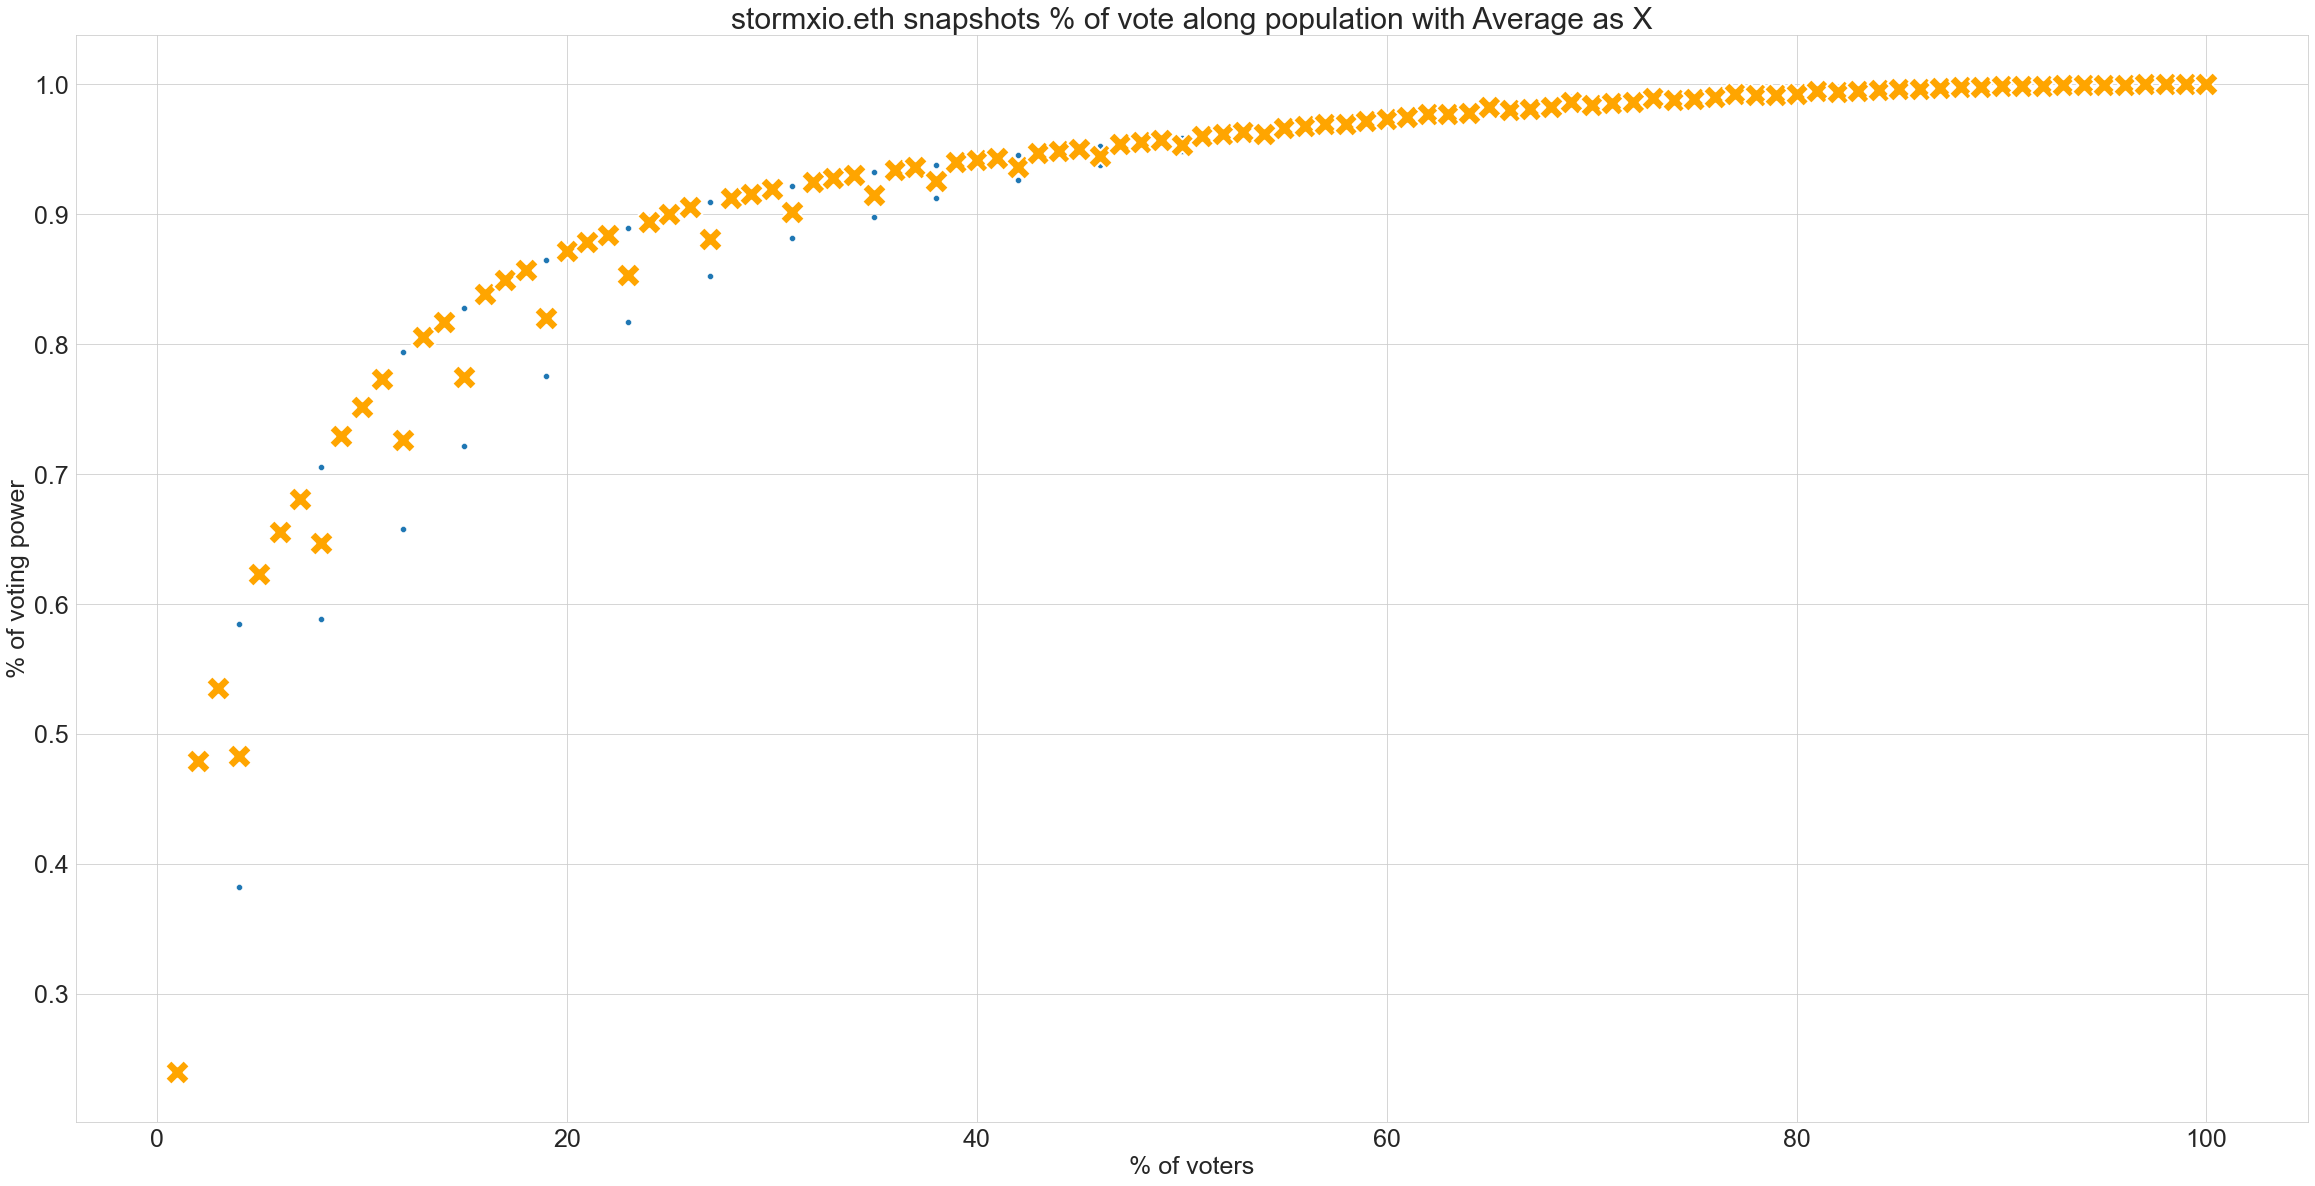

In [546]:
plt.rc("figure", figsize=(40, 20))
sns.set_style("whitegrid")
plt.rc("font", size=25)
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()
##print(data_means)
plot_title = spacename + ' snapshots % of vote along population with Average as X'

ax=sns.scatterplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped").set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')
chart = sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp",zorder=3, s=600,marker='X',color = 'orange')
#and save the chart file, too
plt.savefig(final_file+'\\'+spacename+' vote power distribution.png', dpi=100)

means_data_path =final_file+'\\'+spacename+'_means_'+'.csv'
data_means.to_csv(means_data_path, index = False)

print(chart)
data_means

The chart above shows what % of all possible votes has been cast (Y axis) as each incremental percent of the voting population casts their vote (X axis). Each line is a Proposal and has a unique color, so that a dot on each percent point represents what % of total voting power was accumulated by that group. The color represents which vote was cast.
The Orange X shows the average % of power accumulated across all elections.

AxesSubplot(0.125,0.125;0.775x0.755)


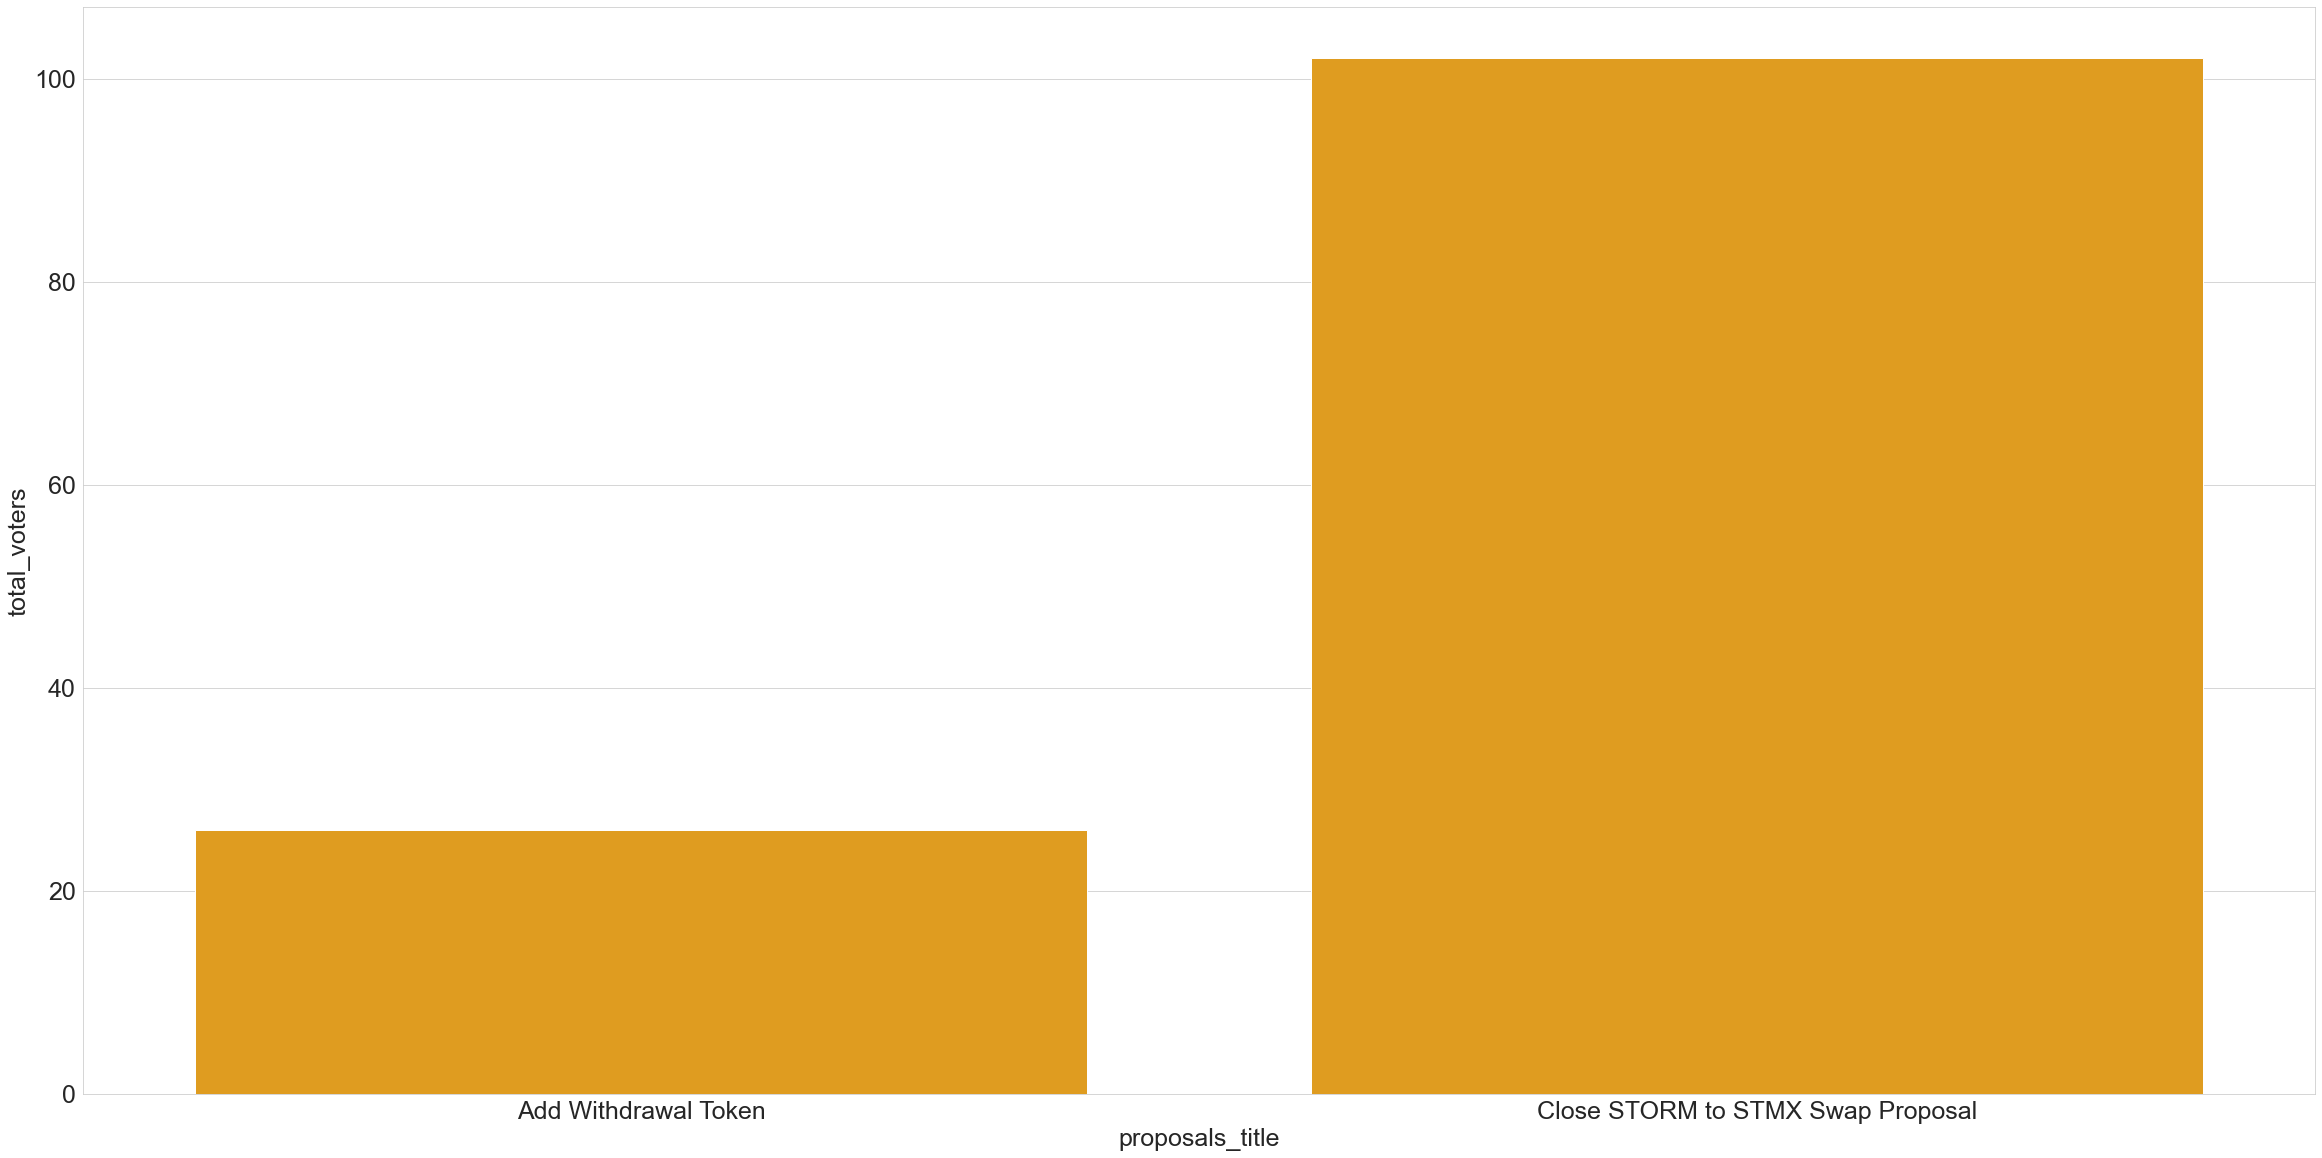

In [547]:
voters_df = db.query("select  proposals_title, count(distinct votes_voter) total_voters,  min(proposal_date) proposal_date from crunch_data group by 1 order by 1 asc").df()

chart = sns.barplot(data=voters_df,x="proposals_title",y="total_voters", color = 'orange')
#and save the chart file, too

print(chart)



AxesSubplot(0.125,0.125;0.775x0.755)


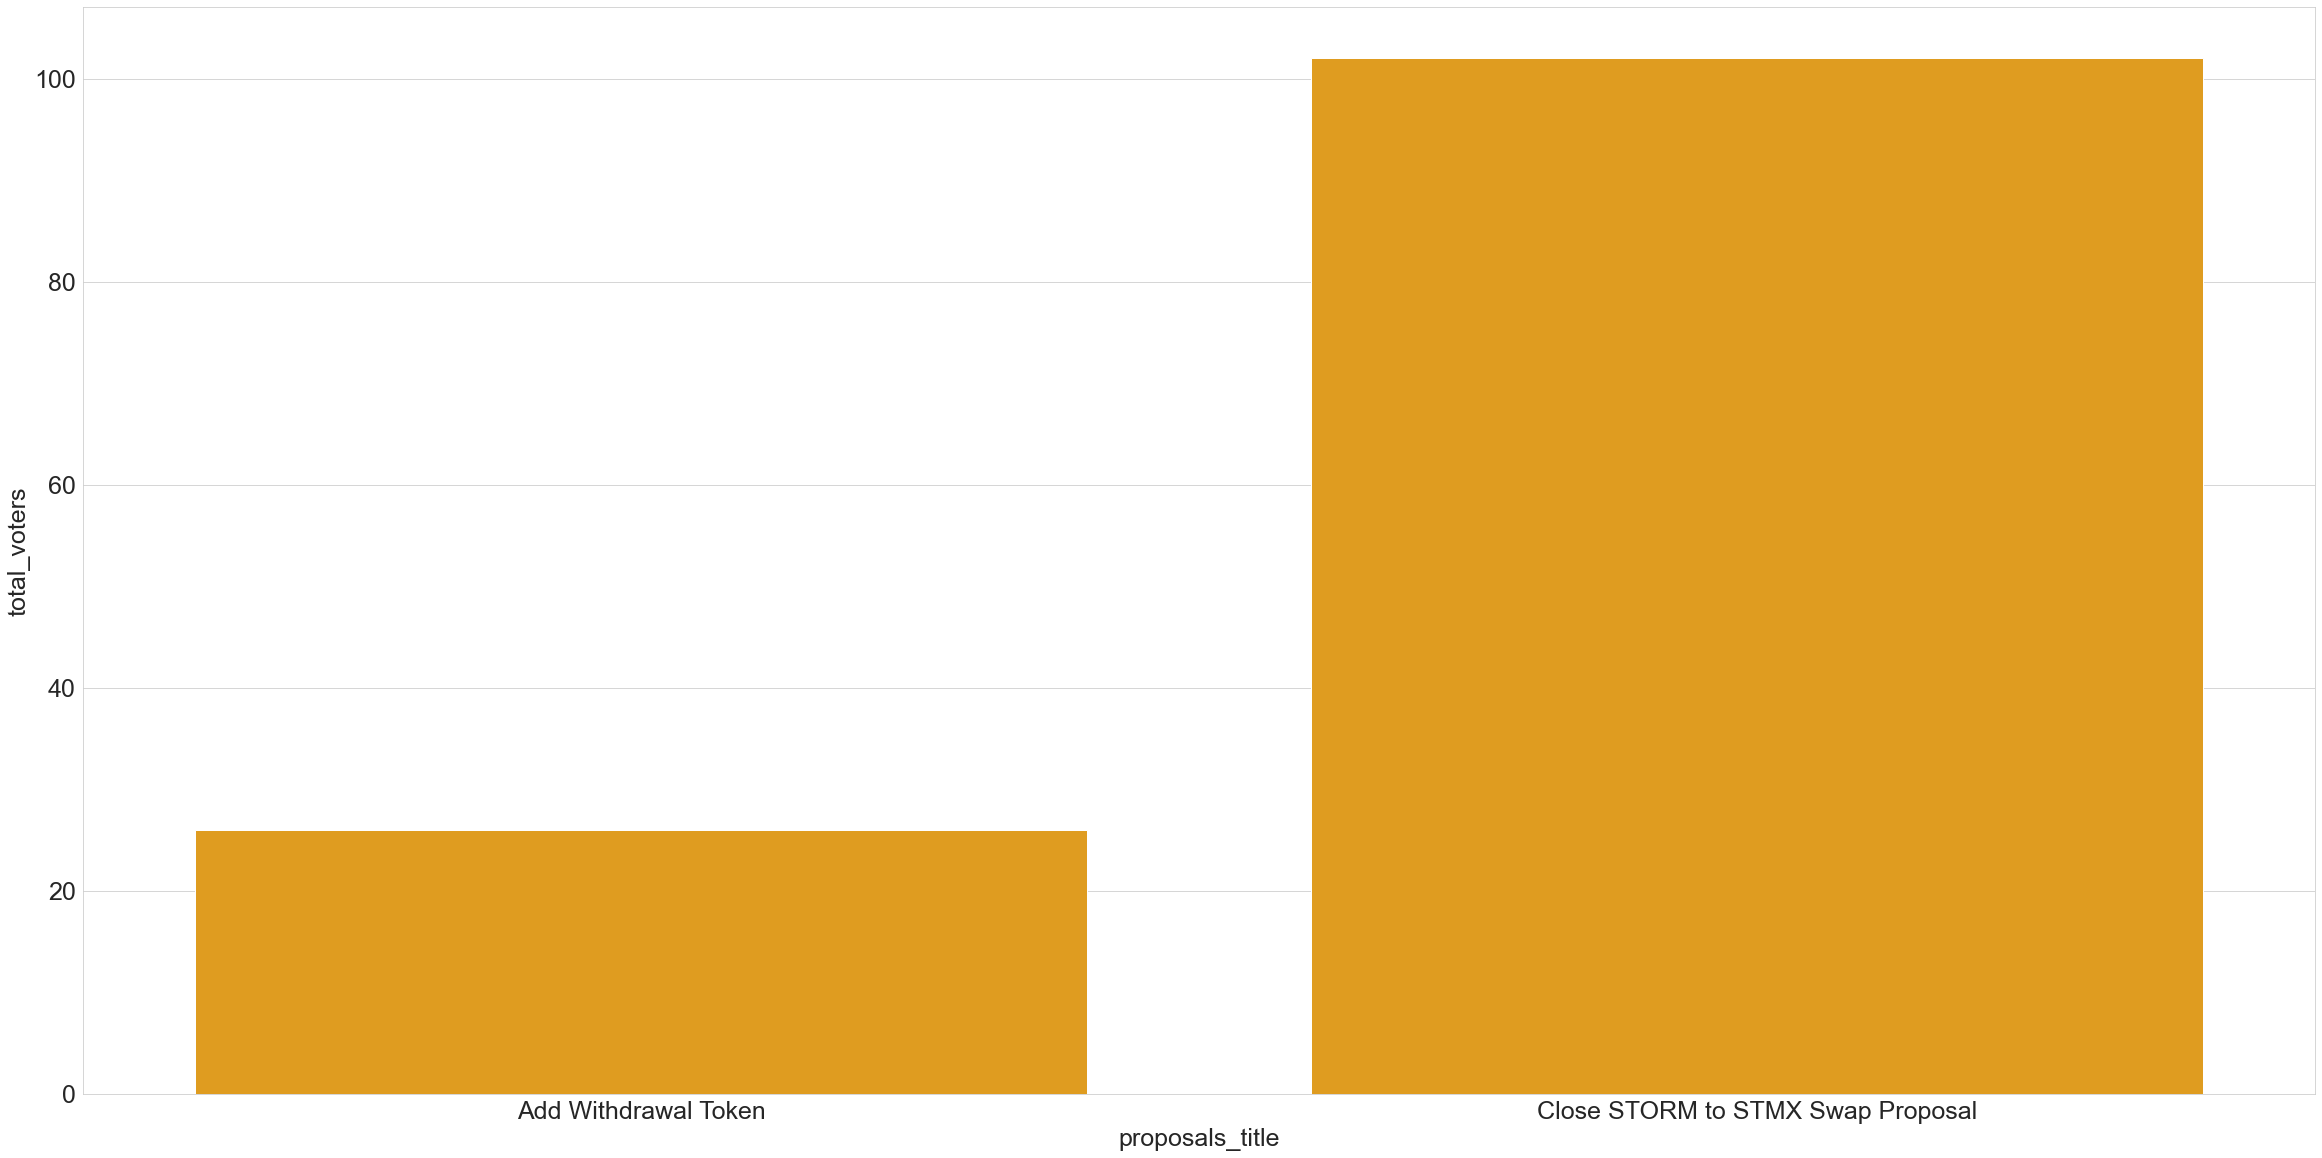

In [548]:
voters_df = db.query("select  proposals_title, count(distinct votes_voter) total_voters,  min(proposal_date) proposal_date from crunch_data group by 1 order by 1 asc").df()

chart = sns.barplot(data=voters_df,x="proposals_title",y="total_voters", color = 'orange')
#and save the chart file, too

print(chart)



In [549]:
p50 = db.query("select min(percentage_voters_counted) "
               "from data_means  where cum_percentage_of_total_vp>=0.5 ").df()
p50display = round(100*(p50.iloc[0,0]),2)
print('On average, a proposal at ', spacename, 'takes ',p50display,'% of the voting population.')

print('A total of ',leader_count, 'wallets have driven the result of all proposals at',spacename,)
print('That\'s', ("{0:.2%}".format(elite)), 'of all DAO voters.')

On average, a proposal at  stormxio.eth takes  2.94 % of the voting population.
A total of  3 wallets have driven the result of all proposals at stormxio.eth
That's 2.80% of all DAO voters.
